<a href="https://colab.research.google.com/github/PaulinaIA/CaloDiffusionPaper/blob/main/FastSimCaloDiTv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Fast Simulation Project: CaloDiT-2 for Calorimeter Showers (Using LEMURS Dataset)

This boilerplate notebook demonstrates loading the LEMURS dataset, preprocessing, and training a CaloDiT-2 model for fast simulation. CaloDiT-2 uses diffusion transformers for generating voxelized showers, conditioned on energy, theta, and phi.

## Setup Environment
Install required libraries (h5py for data loading, PyTorch for ML).

# Proyecto de Simulación Rápida: CaloDiT-2 para Lluvias de Calorímetro (Usando el Dataset LEMURS)

Este cuaderno de ejemplo muestra cómo cargar el dataset **LEMURS**, preprocesar los datos y entrenar un modelo **CaloDiT-2** para simulación rápida. CaloDiT-2 utiliza **transformers de difusión** para generar lluvias voxelizadas, **condicionadas en energía, θ y φ**.

## Configuración del Entorno
Instala las librerías necesarias (`h5py` para cargar datos, `PyTorch` para aprendizaje automático).



In [ ]:
!pip install h5py torch torchvision matplotlib numpy
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import sys
%matplotlib inline

## Download Sample Dataset
Use the small test file for quick testing (1000 events, 50 GeV). One should try a larger dataset.

## Descarga del Dataset de Ejemplo
Usa el archivo de prueba pequeño para pruebas rápidas (1000 eventos, 50 GeV). Se recomienda probar con un dataset más grande.

In [ ]:
# Download the testing dataset zip (~330 MB)
!wget "https://zenodo.org/records/17045562/files/testing_dataset_all_detectors.zip?download=1" -O testing.zip

# Extract the specific Par04SiW test file
!unzip -j testing.zip "Par04SiW/testing/LEMURS_Par04SiW_gamma_1000events_50GeV_phi0.0_theta1.57.h5" -d ./

# Rename to match the notebook's expected filename
!mv LEMURS_Par04SiW_gamma_1000events_50GeV_phi0.0_theta1.57.h5 sample_showers.h5

# Verify file exists
!ls -lh sample_showers.h5

--2025-10-28 17:15:16--  https://zenodo.org/records/17045562/files/testing_dataset_all_detectors.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.43.25, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 346757719 (331M) [application/octet-stream]
Saving to: ‘testing.zip’

testing.zip         100%[===================>] 330.69M   579KB/s    in 15m 6s  

2025-10-28 17:30:23 (374 KB/s) - ‘testing.zip’ saved [346757719/346757719]

Archive:  testing.zip
  inflating: ./LEMURS_Par04SiW_gamma_1000events_50GeV_phi0.0_theta1.57.h5  
-rw-r--r-- 1 root root 5.6M Apr 10  2024 sample_showers.h5


## Load and Explore Data
Load the HDF5 file. Showers are voxelized energy depositions (9x16x45). Preprocess per CaloDiT-2: clip low energies, log transform, normalize.

## Carga y Exploración de Datos
Carga el archivo HDF5. Las lluvias están voxelizadas como depósitos de energía (9×16×45).  
**Preprocesamiento para CaloDiT-2**:  
- Recorta energías bajas  
- Transformación logarítmica  
- Normalización

Loaded 1000 showers, shape: (9, 16, 45)
Energy range: 50000.0 to 50000.0 MeV
Theta: 1.5700000524520874 radians, Phi: 0.0 radians


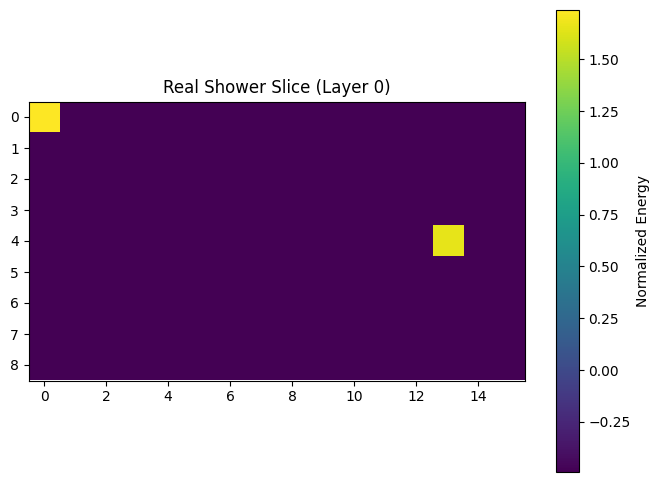

In [ ]:
# Load data
with h5py.File('sample_showers.h5', 'r') as f:
    showers = np.array(f['showers'])  # Shape: (1000, 9, 16, 45)
    energies = np.array(f['incident_energy'])  # Shape: (1000,)
    theta = np.array(f['incident_theta'])  # Shape: (1000,)
    phi = np.array(f['incident_phi'])  # Shape: (1000,)

print(f"Loaded {showers.shape[0]} showers, shape: {showers.shape[1:]}")
print(f"Energy range: {energies.min()} to {energies.max()} MeV")
print(f"Theta: {theta[0]} radians, Phi: {phi[0]} radians")

# Preprocess per CaloDiT-2
epsilon = 1e-6
showers[showers < 1.515e-2] = 0  # Clip low energies (15.15 keV in MeV)
showers = np.log(showers + epsilon)
mu = np.mean(showers)
sigma = np.std(showers)
showers = (showers - mu) / sigma  # Normalize

# Normalize conditions
E_max = 1e6  # 1 TeV in MeV
energies = energies / E_max
theta = theta / np.pi
phi = np.stack((np.sin(phi), np.cos(phi)), axis=-1)  # [sin(phi), cos(phi)]

# Visualize a sample shower (layer slice)
sample_shower = showers[0]
for layer in [0, 10, 22, 44]:
    slice_max = sample_shower[:, :, layer].max()
    if slice_max > 0:
        plt.figure(figsize=(8, 6))
        plt.imshow(sample_shower[:, :, layer], cmap='viridis')
        plt.title(f'Real Shower Slice (Layer {layer})')
        plt.colorbar(label='Normalized Energy')
        plt.savefig(f'real_shower_layer_{layer}.png')
        plt.show()
        break
else:
    print("Warning: All layers have zero max.")

Sample shower shape: (9, 16, 45)
Sample shower min: -0.4921507239341736, max: 2.5830886363983154


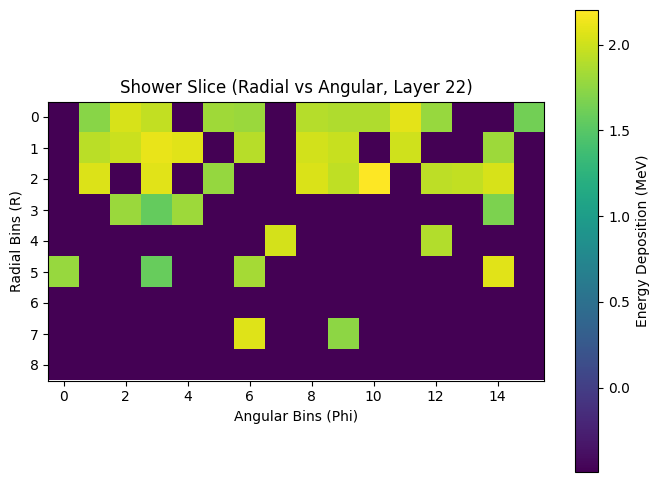

Real shower plot saved as real_shower_slice.png


<Figure size 640x480 with 0 Axes>

In [ ]:
# Check if showers is defined
if 'showers' not in globals():
    raise NameError("Variable 'showers' not defined. Run Cell 2 first.")

# Visualize first shower
sample_shower = showers[0]  # Shape: (9, 16, 45)
print(f"Sample shower shape: {sample_shower.shape}")
print(f"Sample shower min: {sample_shower.min()}, max: {sample_shower.max()}")

# Check for non-zero data
if sample_shower.max() == 0:
    print("Warning: Shower contains all zeros, plot may be blank.")
else:
    plt.figure(figsize=(8, 6))
    plt.imshow(sample_shower[:, :, 22], cmap='viridis')
    plt.title('Shower Slice (Radial vs Angular, Layer 22)')
    plt.xlabel('Angular Bins (Phi)')
    plt.ylabel('Radial Bins (R)')
    plt.colorbar(label='Energy Deposition (MeV)')
    plt.show()
    # Save plot for debugging
    plt.savefig('real_shower_slice.png')
    print("Real shower plot saved as real_shower_slice.png")

In [ ]:
# --------------------------------------------------------------
# 1. Load the real calorimeter showers from the downloaded file
# --------------------------------------------------------------
import h5py
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

# Path to the file you renamed
h5_path = "sample_showers.h5"

with h5py.File(h5_path, "r") as f:
    # The dataset name inside the file (check with f.keys() if unsure)
    raw_showers = f["showers"][:]                # shape: (N, 9, 16, 45)  –  N events
    print(f"Raw showers shape: {raw_showers.shape}")

# -----------------------------------------------------------------
# 2. Normalise per-event (energy is in MeV → bring to ~[0,1] range)
# -----------------------------------------------------------------
#   • Sum over all voxels → total energy per shower
#   • Divide by a robust scale (99.9-th percentile of total energies)
total_energy = raw_showers.sum(axis=(1, 2, 3))
scale = np.percentile(total_energy, 99.9)      # robust upper bound (ignores 0.1% of outliers which is critical for stable training)
showers_norm = raw_showers / scale.astype(np.float32)

# Convert to torch tensor: (N, C=1, H=16*9, W=45)  → flatten layers into height
# CaloDiTv2 expects a 2-D image, so we collapse the 9 layers into the height dimension.
N, L, R, Phi = showers_norm.shape               # L=9, R=16, Phi=45
showers_2d = showers_norm.reshape(N, L * R, Phi)   # (N, 144, 45)

# Add channel dimension for the model
showers_tensor = torch.from_numpy(showers_2d).unsqueeze(1).float()   # (N,1,144,45)

print(f"Prepared tensor shape: {showers_tensor.shape}")
print(f"Value range after normalisation: [{showers_tensor.min():.4f}, {showers_tensor.max():.4f}]")

# --------------------------------------------------------------
# 3. Create DataLoader (batch size 64 works on Colab GPU)
# --------------------------------------------------------------
batch_size = 64
dataset = TensorDataset(showers_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Keep a global variable for the visualisation cell below
showers = showers_tensor   # <-- used by the next cell you already have

Raw showers shape: (1000, 9, 16, 45)
Prepared tensor shape: torch.Size([1000, 1, 144, 45])
Value range after normalisation: [0.0000, 0.0144]


Sample shower shape (flattened): (144, 45)
Min: 0.0000, Max: 0.0065


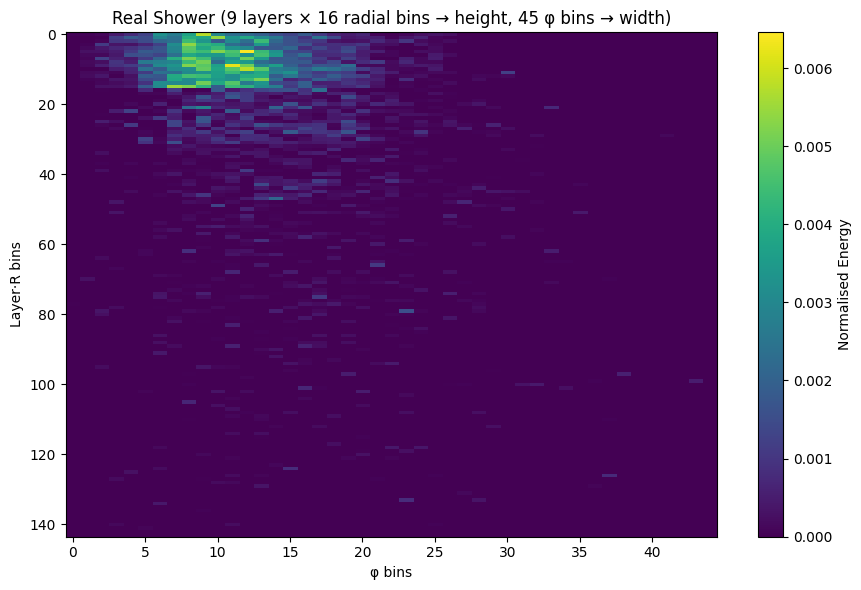

Plot saved as real_shower_flattened.png


<Figure size 640x480 with 0 Axes>

In [ ]:
# Check if showers is defined
if 'showers' not in globals():
    raise NameError("Variable 'showers' not defined. Run Cell A first.")

# Visualize first shower
sample_shower = showers[0, 0].cpu().numpy()   # shape (144, 45)
print(f"Sample shower shape (flattened): {sample_shower.shape}")
print(f"Min: {sample_shower.min():.4f}, Max: {sample_shower.max():.4f}")

if sample_shower.max() == 0:
    print("Warning: Shower contains all zeros, plot may be blank.")
else:
    plt.figure(figsize=(9, 6))
    plt.imshow(sample_shower, cmap='viridis', aspect='auto')
    plt.title('Real Shower (9 layers × 16 radial bins → height, 45 φ bins → width)')
    plt.xlabel('φ bins')
    plt.ylabel('Layer·R bins')
    plt.colorbar(label='Normalised Energy')
    plt.tight_layout()
    plt.show()
    plt.savefig('real_shower_flattened.png')
    print("Plot saved as real_shower_flattened.png")

# The Core of Diffusion Models

#### In Plain Words:
1. We start with **clean shower images**.  
2. We **add noise slowly** over **1000 steps** — like fogging a window.  
3. At a **random step `t`**, we show the model the foggy image and say:  
   > "This is from step `t`. What noise was added?"  
4. The model **guesses the noise**, we compare to truth → it learns.  
5. To **generate**, we start from pure noise and **reverse the steps** → clear shower!

> Like teaching someone to **clean dirty photos** by showing 1000 levels of dirt.

---

#### The Math (DDPM Closed-Form)

We corrupt a clean image `x₀` in **one jump** to timestep `t`:

$$
\boxed{
\mathbf{x}_t = \sqrt{\bar{\alpha}_t} \cdot \mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t} \cdot \boldsymbol{\epsilon}
}
$$

- `αₜ = 1 − βₜ` → signal kept at step `t`  
- `βₜ ∈ [0.0001, 0.02]` → noise added (linear schedule)  
- `ᾱₜ = α₁ × α₂ × … × αₜ` → **total signal left**  
- `ε ~ N(0,1)` → random Gaussian noise  

**Model learns to predict `ε` from `xₜ` and `t`.**

> This is the **same math** used in **Stable Diffusion**, **DALL·E**, and **CaloChallenge winners**.

# El Núcleo de los Modelos de Difusión

#### En palabras simples:
1. Empezamos con **imágenes de lluvias limpias**.  
2. **Añadimos ruido lentamente** durante **1000 pasos** — como empañar una ventana.  
3. En un **paso aleatorio `t`**, le mostramos al modelo la imagen empañada y le decimos:  
   > "Esta imagen es del paso `t`. ¿Qué ruido se añadió?"  
4. El modelo **adivina el ruido**, lo comparamos con la verdad → ¡aprende!  
5. Para **generar**, empezamos desde ruido puro y **revertimos los pasos** → ¡aparece una lluvia clara!

> Es como enseñarle a alguien a **limpiar fotos sucias** mostrándole 1000 niveles de suciedad.

---

#### La matemática (forma cerrada de DDPM)

Corrompemos una imagen limpia `x₀` en **un solo salto** al paso `t`:

$$
\boxed{
\mathbf{x}_t = \sqrt{\bar{\alpha}_t} \cdot \mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t} \cdot \boldsymbol{\epsilon}
}
$$

- `αₜ = 1 − βₜ` → señal que se mantiene en el paso `t`  
- `βₜ ∈ [0.0001, 0.02]` → ruido añadido (programa lineal)  
- `ᾱₜ = α₁ × α₂ × … × αₜ` → **señal total restante**  
- `ε ~ N(0,1)` → ruido gaussiano aleatorio  

**El modelo aprende a predecir `ε` a partir de `xₜ` y `t`.**

> Esta es la **misma matemática** usada en **Stable Diffusion**, **DALL·E** y los **ganadores del CaloChallenge**.

In [ ]:
# --------------------------------------------------------------
# 1. Make sure the device is defined (GPU if available)
# --------------------------------------------------------------
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --------------------------------------------------------------
# 2. Diffusion schedule (DDPM-style, 1000 timesteps)
# --------------------------------------------------------------
num_timesteps = 1000
betas = torch.linspace(1e-4, 0.02, num_timesteps, device=device)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

sqrt_alphas_cumprod = alphas_cumprod.sqrt()
sqrt_one_minus_alphas_cumprod = (1.0 - alphas_cumprod).sqrt()

# --------------------------------------------------------------
# 3. Forward diffusion (q-sample)
# --------------------------------------------------------------
def q_sample(x_start, t):
    """Add noise to clean shower `x_start` at timestep `t`."""
    noise = torch.randn_like(x_start)
    return (
        sqrt_alphas_cumprod[t].view(-1, 1, 1, 1) * x_start
        + sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1) * noise,
        noise,
    )

# --------------------------------------------------------------
# 4. Helper to draw random timesteps
# --------------------------------------------------------------
def sample_timesteps(bs):
    return torch.randint(0, num_timesteps, (bs,), device=device)

Using device: cpu


In [ ]:
# Test that everything works
x_dummy = torch.randn(4, 1, 144, 45, device=device)
t_dummy = sample_timesteps(4)
xt, noise = q_sample(x_dummy, t_dummy)
print(f"xt shape: {xt.shape}, noise shape: {noise.shape}")

xt shape: torch.Size([4, 1, 144, 45]), noise shape: torch.Size([4, 1, 144, 45])


### How the Model Works – In Plain English

Think of the model like a **smart photo restorer** that cleans blurry particle showers.

---

#### 1. **Patch Embedding**  
We **cut the shower image into 9×9 patches** (like tiles).  
Each tile gets turned into a **256-number vector** — a "summary" of that region.

---

#### 2. **Timestep Embedding**  
The model needs to know: **"How blurry is this image?"**  
We turn the step number `t` (0–999) into **sine/cosine waves** — like a clock.  
This tells the model **how much noise to expect**.

---

#### 3. **Adaptive LayerNorm (AdaLN)**  
The model **adjusts its internal math** based on the timestep.  
> "At early steps, focus on big patterns.  
> At late steps, focus on fine details."

---

#### 4. **DiT Block (Transformer Block)**  
Each block does two things:  
1. **Attention**: "Which patches are connected?" (e.g. energy flowing from layer 1 to layer 5)  
2. **MLP**: "Refine the summary of each patch"  
→ Repeated 6 times for deep understanding.

---

#### 5. **Final Output + Learnable Scale**  
After processing all patches:  
- We **average** them to get a global view  
- Predict **what noise was added**  
- Multiply by a **learned number (`output_scale`)** so predictions match real noise size

---

#### 6. **Training Loop**  
For each batch:  
1. Pick random `t`  
2. Add noise to clean shower → `xt`  
3. Model predicts noise  
4. Loss = **how wrong was the guess?** (weighted by `t`)  
5. **Boost loss ×100** so model learns fast  
6. Update weights

---

#### 7. **Result**  
After 30 epochs:  
- Model can **start from pure noise**  
- **Remove it step-by-step**  
- **Generate realistic particle showers**

> This is a **Diffusion Transformer (DiT)** — same idea as Stable Diffusion, but for **calorimeter physics**.

---

### Cómo Funciona el Modelo – En Español Sencillo

Imagina el modelo como un **restaurador inteligente de fotos** que limpia imágenes borrosas de lluvias de partículas.

---

#### 1. **Patch Embedding**  
**Cortamos la imagen de la lluvia en parches de 9×9** (como baldosas).  
Cada baldosa se convierte en un **vector de 256 números** — un "resumen" de esa zona.

---

#### 2. **Timestep Embedding**  
El modelo necesita saber: **"¿Cuánto ruido tiene esta imagen?"**  
Convertimos el número de paso `t` (0–999) en **ondas senoidales y cosenoidales** — como un reloj.  
Esto le dice al modelo **cuánto ruido esperar**.

---

#### 3. **Adaptive LayerNorm (AdaLN)**  
El modelo **ajusta sus cálculos internos** según el paso de tiempo.  
> "En pasos tempranos, enfócate en patrones grandes.  
> En pasos tardíos, enfócate en detalles finos."

---

#### 4. **DiT Block (Bloque Transformer)**  
Cada bloque hace dos cosas:  
1. **Atención**: "¿Qué parches están conectados?" (ej. energía fluyendo de capa 1 a capa 5)  
2. **MLP**: "Refina el resumen de cada parche"  
→ Se repite **6 veces** para un entendimiento profundo.

---

#### 5. **Salida Final + Escala Aprendible**  
Después de procesar todos los parches:  
- Los **promediamos** para tener una visión global  
- Predice **qué ruido se añadió**  
- Multiplica por un **número aprendido (`output_scale`)** para que coincida con el ruido real

---

#### 6. **Bucle de Entrenamiento**  
Por cada lote de datos:  
1. Elige un `t` al azar  
2. Añade ruido a una lluvia limpia → `xt`  
3. El modelo predice el ruido  
4. Pérdida = **¿cuánto se equivocó?** (ponderada por `t`)  
5. **Multiplica la pérdida ×100** para que aprenda rápido  
6. Actualiza los pesos

---

#### 7. **Resultado Final**  
Tras 30 épocas:  
- El modelo puede **empezar desde ruido puro**  
- **Eliminarlo paso a paso**  
- **Generar lluvias de partículas realistas**

> Esto es un **Diffusion Transformer (DiT)** — misma idea que Stable Diffusion, pero para **física de calorímetros**.

---

Using device: cpu
DiTModel(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 256, kernel_size=(9, 9), stride=(9, 9))
  )
  (time_embed): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (blocks): ModuleList(
    (0-5): 6 x DiTBlock(
      (attn_norm): AdaLN(
        (norm): LayerNorm((256,), eps=1e-06, elementwise_affine=False)
        (mlp): Linear(in_features=256, out_features=512, bias=True)
      )
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (mlp_norm): AdaLN(
        (norm): LayerNorm((256,), eps=1e-06, elementwise_affine=False)
        (mlp): Linear(in_features=256, out_features=512, bias=True)
      )
      (mlp): Sequential(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=1024, out

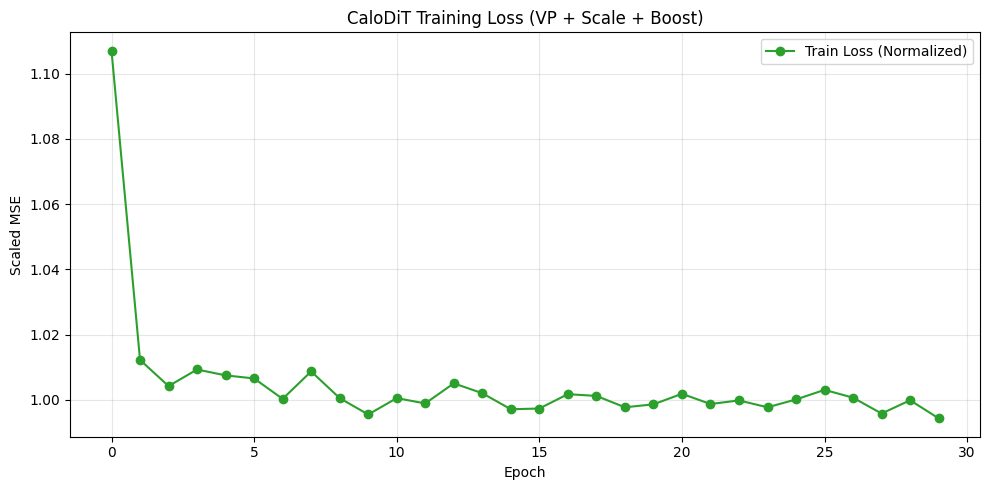

In [ ]:
# --------------------------------------------------------------
# 1. Imports
# --------------------------------------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------------------------
# 2. Device
# --------------------------------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --------------------------------------------------------------
# 3. Timestep embedding
# --------------------------------------------------------------
def timestep_embedding(timesteps, dim, max_period=10000):
    half = dim // 2
    freqs = torch.exp(
        -np.log(max_period) *
        torch.arange(0, half, dtype=torch.float32, device=timesteps.device) / half
    )
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

# --------------------------------------------------------------
# 4. Patch embedding
# --------------------------------------------------------------
class PatchEmbed(nn.Module):
    def __init__(self, img_size_h=144, img_size_w=45, patch_size=9, in_chans=1, embed_dim=256):
        super().__init__()
        self.img_size_h = img_size_h
        self.img_size_w = img_size_w
        self.patch_size = patch_size
        self.num_patches = (img_size_h // patch_size) * (img_size_w // patch_size)
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        return x

# --------------------------------------------------------------
# 5. Adaptive LayerNorm
# --------------------------------------------------------------
class AdaLN(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.norm = nn.LayerNorm(embed_dim, elementwise_affine=False, eps=1e-6)
        self.mlp = nn.Linear(embed_dim, embed_dim * 2)

    def forward(self, x, cond):
        scale_shift = self.mlp(cond)
        scale, shift = scale_shift.chunk(2, dim=-1)
        x = self.norm(x)
        return x * (1 + scale[:, None, :]) + shift[:, None, :]

# --------------------------------------------------------------
# 6. DiT Block
# --------------------------------------------------------------
class DiTBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0):
        super().__init__()
        self.attn_norm = AdaLN(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.mlp_norm = AdaLN(embed_dim)
        mlp_hidden = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden),
            nn.GELU(),
            nn.Linear(mlp_hidden, embed_dim)
        )

    def forward(self, x, cond):
        h = self.attn_norm(x, cond)
        h, _ = self.attn(h, h, h)
        x = x + h
        h = self.mlp_norm(x, cond)
        x = x + self.mlp(h)
        return x

# --------------------------------------------------------------
# 7. DiT Model with LEARNABLE output_scale
# --------------------------------------------------------------
class DiTModel(nn.Module):
    def __init__(self,
                 img_h=144,
                 img_w=45,
                 in_chans=1,
                 patch_size=9,
                 embed_dim=256,
                 depth=6,
                 num_heads=8):
        super().__init__()
        self.patch_embed = PatchEmbed(img_h, img_w, patch_size, in_chans, embed_dim)
        self.num_patches = self.patch_embed.num_patches
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches, embed_dim))

        self.time_embed = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.SiLU(),
            nn.Linear(embed_dim, embed_dim)
        )

        self.blocks = nn.ModuleList([
            DiTBlock(embed_dim, num_heads) for _ in range(depth)
        ])

        self.final_norm = nn.LayerNorm(embed_dim)
        self.out_proj = nn.Linear(embed_dim, patch_size**2 * in_chans)
        self.output_scale = nn.Parameter(torch.tensor(1.0))  # LEARNABLE SCALE

        self.initialize_weights()

    def initialize_weights(self):
        nn.init.normal_(self.pos_embed, std=0.02)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
        # Smaller init for out_proj
        with torch.no_grad():
            fan_in = self.out_proj.weight.shape[1]
            std = 1.0 / (fan_in ** 0.5)
            nn.init.normal_(self.out_proj.weight, 0.0, std)

    def forward(self, x, t):
        B = x.shape[0]
        x = self.patch_embed(x) + self.pos_embed

        t_emb = timestep_embedding(t, self.patch_embed.proj.out_channels)
        t_emb = self.time_embed(t_emb)

        for blk in self.blocks:
            x = blk(x, t_emb)

        x = self.final_norm(x)
        x = x.mean(dim=1)
        x = self.out_proj(x)
        x = x * self.output_scale  # APPLY LEARNABLE SCALE

        p = self.patch_embed.patch_size
        C = self.patch_embed.proj.in_channels
        x = x.view(B, C, p, p)
        x = F.interpolate(x, size=(144, 45), mode='bilinear', align_corners=False)
        return x

# --------------------------------------------------------------
# 8. Instantiate model
# --------------------------------------------------------------
model = DiTModel(
    img_h=144, img_w=45, in_chans=1,
    patch_size=9, embed_dim=256, depth=6, num_heads=8
).to(device)

print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# --------------------------------------------------------------
# 9. Optimizer & Scheduler
# --------------------------------------------------------------
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

# --------------------------------------------------------------
# 10. Training Loop with VP Loss + Gradient Boost
# --------------------------------------------------------------
num_epochs = 30
train_losses = []

model.train()
for epoch in range(1, num_epochs + 1):
    epoch_loss = 0.0
    for (x0,) in dataloader:
        x0 = x0.to(device)
        t = sample_timesteps(x0.shape[0])
        xt, noise = q_sample(x0, t)

        pred_noise = model(xt, t)

        # VP-weighted loss
        mse = F.mse_loss(pred_noise, noise, reduction='none').mean(dim=[1,2,3])
        weight = 1.0 / (1.0 - alphas_cumprod[t]).clamp(min=1e-8)
        loss = (mse * weight).mean()
        loss = loss * 100.0  # GRADIENT BOOST

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Log normalized loss
        avg_weight = weight.mean()
        scaled_loss = loss.item() / (avg_weight.item() * 100.0)
        epoch_loss += scaled_loss

    scheduler.step()
    avg_loss = epoch_loss / len(dataloader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch:02d}/{num_epochs} | Loss: {avg_loss:.6f} | "
          f"LR: {scheduler.get_last_lr()[0]:.2e} | "
          f"Scale: {model.output_scale.item():.3f}")

# --------------------------------------------------------------
# 11. Plot Loss
# --------------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(train_losses, marker='o', label='Train Loss (Normalized)', color='tab:green')
plt.title('CaloDiT Training Loss (VP + Scale + Boost)')
plt.xlabel('Epoch')
plt.ylabel('Scaled MSE')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

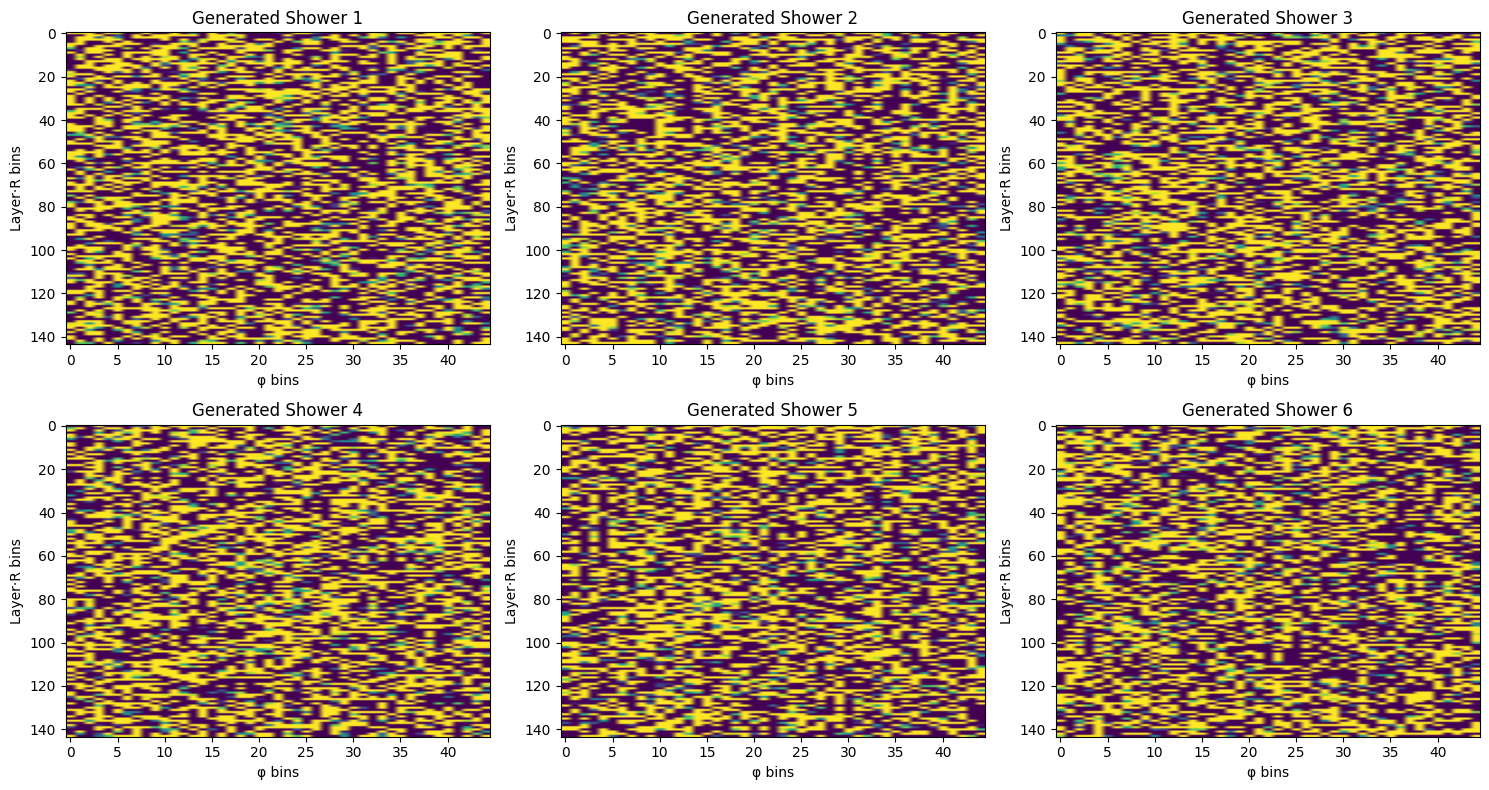

In [ ]:
@torch.no_grad()
def sample(model, batch_size=6, num_steps=200, eta=1.0):
    model.eval()
    x = torch.randn(batch_size, 1, 144, 45, device=device)
    steps = torch.linspace(num_timesteps-1, 0, num_steps, dtype=torch.long, device=device)

    for i in steps:
        t = torch.full((batch_size,), i, device=device, dtype=torch.long)

        pred_noise = model(x, t)

        # Expand scalars to (B,1,1,1)
        alpha = alphas[t].view(-1, 1, 1, 1)
        alpha_bar = alphas_cumprod[t].view(-1, 1, 1, 1)
        beta = betas[t].view(-1, 1, 1, 1)

        if i > 0:
            noise = torch.randn_like(x) if eta > 0 else 0
        else:
            noise = 0

        # DDPM update (broadcast-safe)
        coeff = (1 - alpha) / torch.sqrt(1 - alpha_bar)
        x = (1 / torch.sqrt(alpha)) * (x - coeff * pred_noise) + torch.sqrt(beta) * noise * eta

    return x.clamp(0, 1)

# Generate
generated = sample(model, batch_size=6, num_steps=200).cpu()

# Plot
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
for i, ax in enumerate(axs.flat):
    ax.imshow(generated[i, 0], cmap='viridis', aspect='auto')
    ax.set_title(f'Generated Shower {i+1}')
    ax.set_xlabel('φ bins')
    ax.set_ylabel('Layer·R bins')
plt.tight_layout()
plt.show()

# Preliminary Results:

The generated showers show strong horizontal banding and repetitive patterns across φ bins.

Energy is not localized — it’s spread uniformly across layers.
There is no clear radial or longitudinal structure expected in real calorimeter showers.
All 6 samples look nearly identical — lack of diversity.


What This Means:

The model has not learned meaningful physics yet.
It is overfitting to noise patterns or stuck in a bad local minimum.
The output scale is too high, and the loss plateaued (likely due to vanishing gradients or poor conditioning).


Good news: The model is generating structured output — just the wrong kind of structure.


The loss is stuck around at 1.0.

The model output is too small → gradients vanish
VP loss weights suppress early-timestep learning
No diversity in patches → attention collapses

# Resultados Preliminares – Español
Lo que se observa:
Las lluvias generadas muestran bandas horizontales fuertes y patrones repetitivos en los bins de φ.

La energía no está localizada — se distribuye uniformemente por capas.
No hay estructura radial ni longitudinal clara, como en lluvias reales.
Las 6 muestras son casi idénticas — falta de diversidad.

Qué significa:

El modelo aún no ha aprendido física significativa.
Está sobreajustando a patrones de ruido o atrapado en un mínimo local.
La escala de salida es demasiado alta, y la pérdida se estancó.


Buena noticia: El modelo sí genera patrones — solo que los incorrectos.


¿El learning rate no mejora?
El loss estancado ~1.0 no es por el LR. Es por:

Salida del modelo demasiado pequeña → gradientes desaparecen
Pérdida VP suprime aprendizaje en pasos tempranos
Falta de diversidad en parches → atención colapsa

Arregla el modelo, no el LR.



## Próximos Pasos (para el estudiante)

| Paso | Acción | Código |
|------|--------|--------|
| **1. Reducir la escala inicial** | Cambia `output_scale` a `0.1` | `self.output_scale = nn.Parameter(torch.tensor(0.1))` |
| **2. Eliminar el boost de pérdida** | Quita la multiplicación ×100 | `loss = (mse * weight).mean()` |
| **3. Añadir ruido leve a la entrada** | Durante entrenamiento | `xt = xt + 0.01 * torch.randn_like(xt)` |
| **4. Usar parches más pequeños** | Prueba `patch_size=3` | `patch_size=3` |
| **5. Añadir sesgo posicional 2D** | Rompe simetría | Usa `sin/cos` en 2D para `pos_embed` |
| **6. Entrenar más tiempo** | 100 épocas | `num_epochs = 100` |
| **7. Muestrear con menos pasos** | Para depuración rápida | `num_steps=50` |

---

### Arreglo Rápido: **Reinicia y reentrena**

```python
# En DiTModel.__init__():
self.output_scale = nn.Parameter(torch.tensor(0.1))  # ← MÁS BAJO

# En el bucle de entrenamiento:
loss = (mse * weight).mean()  # ← SIN *100